In [1]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')
        return out

In [2]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label = 'e'

d = e + c
d.label = 'd'
d

f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
L


Value(data=-8.0)

In [3]:
d._op, d._prev

('+', {Value(data=-6.0), Value(data=10.0)})

In [4]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

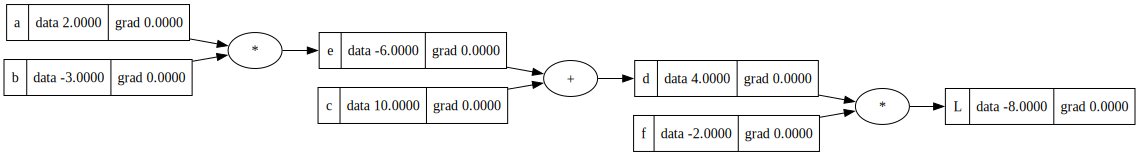

In [5]:
draw_dot(L)

In [6]:
# we have obtained a graph containing the gradients (as 0.0)
# By the Chain Rule, we know that if we want to know the dL with respect to dc (not an inmediate relationship, as it is further down in the graph)
# we have to operate as:
# dL / dc = (dL / dd) * (dd / dc)

# "If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."

In [7]:
# In the case of an addition, such as d = c + e, we know that the derivate of d with respect to c (dd / dc), is 1.
# Then, this means that the Chain Rule for the example above would become dL / dc = (dL / dd) * 1
# The derivative of an addition, is just passing the gradient along to the next step!

In [8]:
# now, if we have a neuron with two inputs we will have tanh(SUM(wi * xi) + b)
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights multiply each input, so we need w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# we also need the bias of the neuron
b = Value(6.7, label='b')

x1w1 = x1*w1
x1w1.label = 'x1w1'

x2w2 = x2*w2
x2w2.label = 'x2w2'

w = x1w1 + x2w2
w.label = 'w'

n = w + b
n.label = 'n'

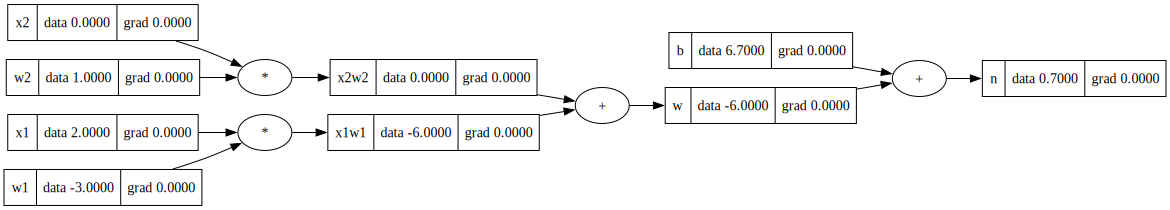

In [9]:
draw_dot(n)

In [10]:
# the most important gradients would be the gradients for W1 and W2, as those are the ones we are going to adjust.
# in this case, the gradient of W2 will be 0, as X2 and it doesn't matter what value W2 has, it will not change because of that multiplication.
# so for this neuron with these inputs, the important weight to adjust will be W1.

In [11]:
# updating the Value class for back propagation

In [12]:
import math

class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None # leafs nodes don't need backward pass (bias is a leaf node)
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

In [13]:
# now, if we have a neuron with two inputs we will have tanh(SUM(wi * xi) + b)
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights multiply each input, so we need w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# we also need the bias of the neuron
b = Value(6.88137358, label='b')

x1w1 = x1*w1
x1w1.label = 'x1w1'

x2w2 = x2*w2
x2w2.label = 'x2w2'

w = x1w1 + x2w2
w.label = 'w'

n = w + b
n.label = 'n'

o = n.tanh()
o.label = 'o'

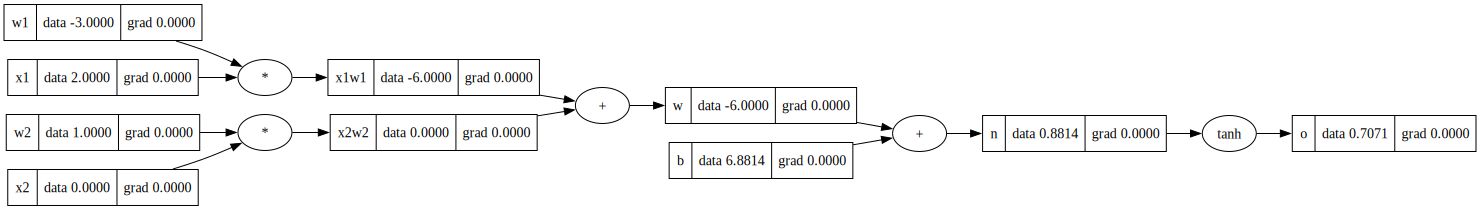

In [14]:
draw_dot(o)

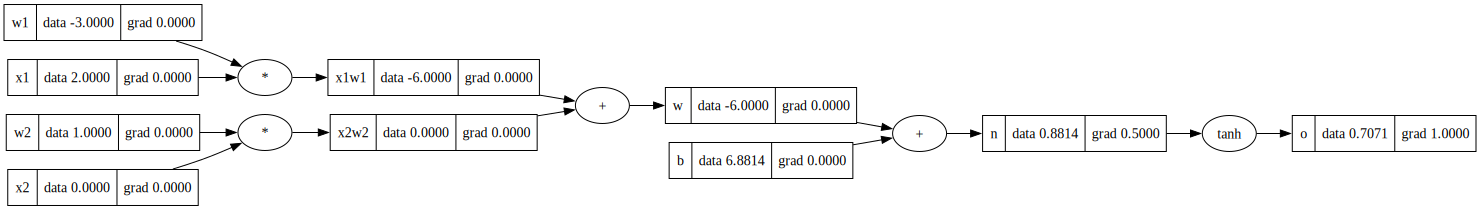

In [15]:
o.grad = 1.0
o._backward()
draw_dot(o)

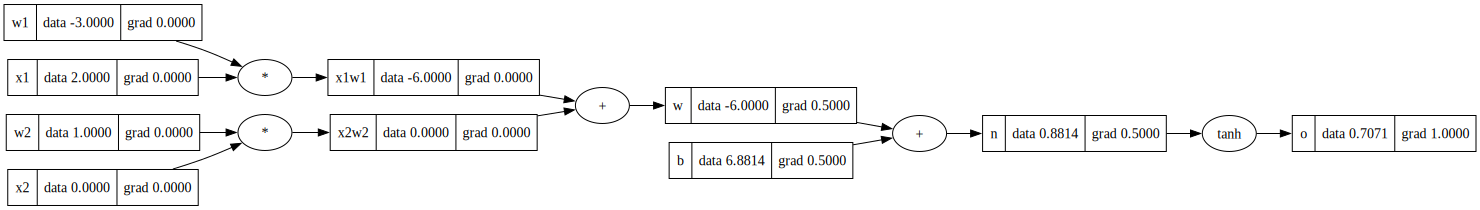

In [16]:
n._backward()
draw_dot(o)

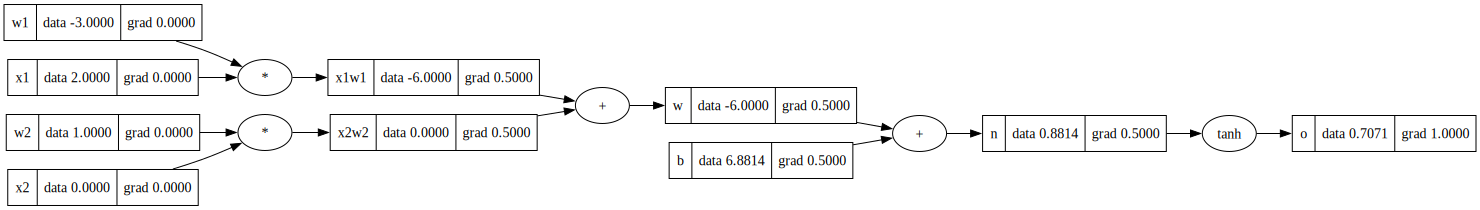

In [17]:
w._backward()
draw_dot(o)

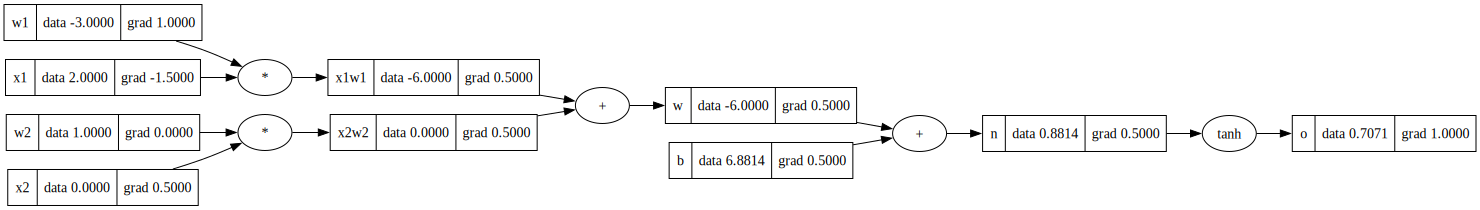

In [18]:
x1w1._backward()
x2w2._backward()
draw_dot(o)

In [19]:
# for executing the backward pass on all the net in a more automated way, we need to walk
# with a topological order as we did manually. The algo for that is as follows:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)
topo

[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.88137358),
 Value(data=0.88137358),
 Value(data=0.707106777676776)]

In [88]:
# We will now redefine our Value class to implement this as
# a backward function for general back pass.

# we also add all the necessary operations to perform backward steps

import math

class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None # leafs nodes don't need backward pass (bias is a leaf node)
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # this will allow instructions like Value(2) + 2
        out = Value(self.data + other.data, _children=(self, other), _op='+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) # this will allow instructions like Value(2) * 2
        out = Value(self.data * other.data, _children=(self, other), _op='*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self, ), f'**{other}')
    
        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad

        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * -1
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __rtruediv__(self, other):
        return other * self**-1
    
    def __rmul__(self, other): # allows instructions such as 2 * Value(2)
        return self * other

    def __radd__(self, other): # allows instructions such as 2 + Value(2)
        return self + other
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return other + (-self)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.grad * out.grad

        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        o.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [89]:
# now, if we have a neuron with two inputs we will have tanh(SUM(wi * xi) + b)
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights multiply each input, so we need w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# we also need the bias of the neuron
b = Value(6.88137358, label='b')

x1w1 = x1*w1
x1w1.label = 'x1w1'

x2w2 = x2*w2
x2w2.label = 'x2w2'

w = x1w1 + x2w2
w.label = 'w'

n = w + b
n.label = 'n'

o = n.tanh()
o.label = 'o'

In [90]:
o.backward()

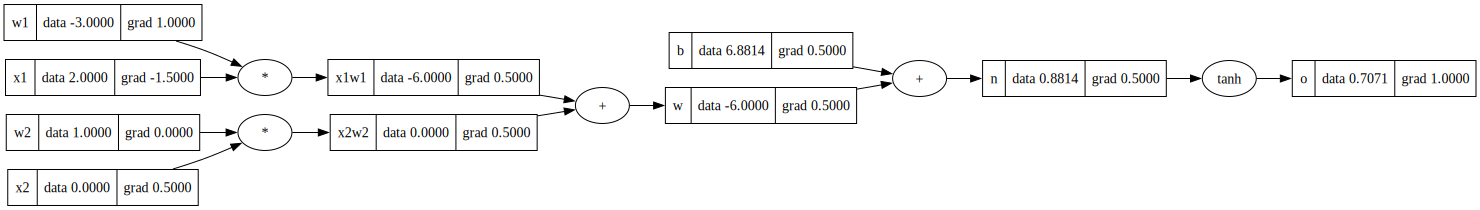

In [91]:
draw_dot(o)

In [131]:
# let's check all the operations in tanh

# now, if we have a neuron with two inputs we will have tanh(SUM(wi * xi) + b)
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights multiply each input, so we need w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# we also need the bias of the neuron
b = Value(6.88137358, label='b')

x1w1 = x1*w1
x1w1.label = 'x1w1'

x2w2 = x2*w2
x2w2.label = 'x2w2'

w = x1w1 + x2w2
w.label = 'w'

n = w + b
n.label = 'n'

# -----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# -----
o.label = 'o'

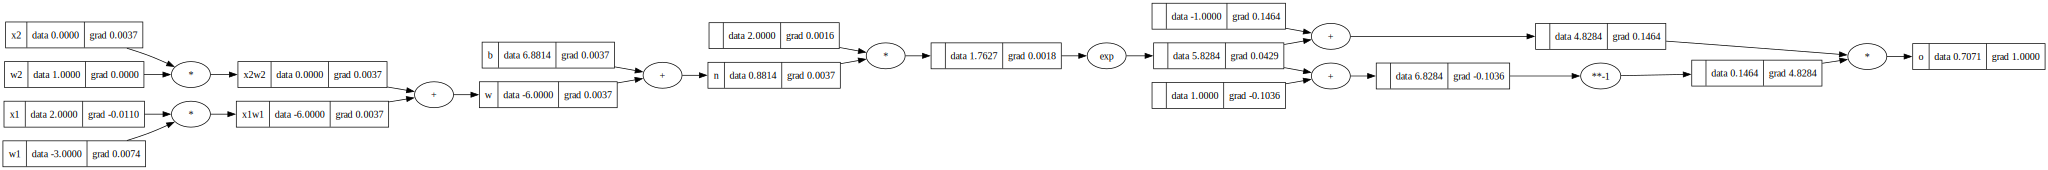

In [132]:
o.backward()
draw_dot(o)

In [96]:
# doing the same in pytorch

In [103]:
import torch

x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True

x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True

w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True

b = torch.Tensor([6.88137358]).double()
b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

0.7071066904050358


In [105]:
print(f"{x2.grad.item()=}\n{w2.grad.item()=}\n{x1.grad.item()=}\n{w1.grad.item()=}")

x2.grad.item()=0.5000001283844369
w2.grad.item()=0.0
x1.grad.item()=-1.5000003851533106
w1.grad.item()=1.0000002567688737


In [133]:
# now we are ready to build our own neural networks
import random

class Neuron:

    def __init__(self, n_inputs):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_inputs)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
        out = act.tanh()
        return out
        

class Layer:

    # A layer is just a list of neurons
    # The num of neurons comes defined by the num of outputs the user wants
    def __init__(self, n_inputs, n_output):
        self.neurons = [Neuron(n_inputs) for _ in range(n_output)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    

class MLP:

    # A MLP is a list of layers
    # Different layers have different inputs and outputs, defined by lists
    def __init__(self, n_inputs, n_outputs):
        sz = [n_inputs] + n_outputs
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(n_outputs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


x = [2.0, 3.0]
n = Neuron(2)
print(n(x))

n = Layer(2, 3)
print(n(x))

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
print(n(x))

Value(data=-0.9956282720935168)
[Value(data=-0.9874929519818259), Value(data=-0.9814562153869818), Value(data=0.90008378036605)]
Value(data=-0.15158036320346466)


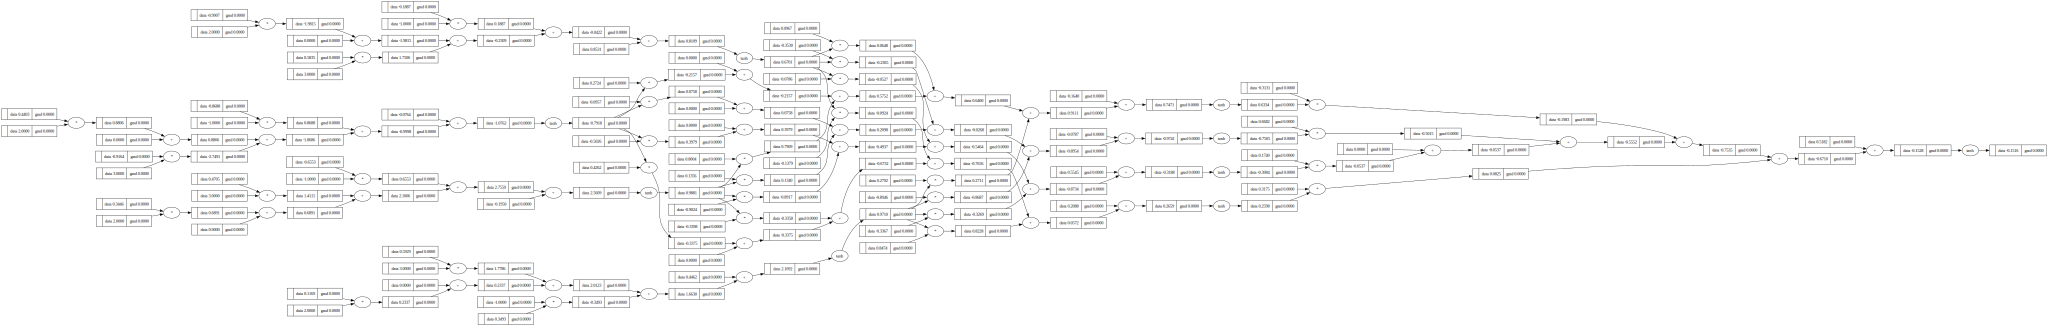

In [134]:
draw_dot(n(x))

In [135]:
# lets train and understand what a loss is with a fake dataset

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.4 , 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # targets
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.15158036320346466),
 Value(data=0.5613943359298077),
 Value(data=0.34849485965920185),
 Value(data=-0.07856805763238549)]

In [136]:
# to tune the weights and calculate a single number that contains how well the net is doing, we use a loss
# we want to minimize the loss
# In this case, the Mean Squared Error loss
loss = sum((yout - ytruth)**2 for ytruth, yout in zip(ys, ypred))
loss

Value(data=6.745837046661696)

In [137]:
loss.backward()

In [142]:
n.layers[0].neurons[0].w[2].grad

0.0